In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd
import numpy as np

from qubx.data.helpers import loader
from qubx.data.readers import AsFundingPayments
from qubx.core.basics import FundingPayment
from qubx.data.helpers import ReaderRegistry
from qubx.core.basics import DataType
from qubx.core.interfaces import IStrategy, IStrategyContext, MarketEvent, Signal, IStrategyInitializer
from qubx.backtester.simulator import simulate


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.63
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
# ld = loader("BINANCE.UM", "1h", source="mqdb::quantlab")
ld = ReaderRegistry.get("mqdb::quantlab")

In [3]:
fd = ld.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-10",
    transform=AsFundingPayments(),
    data_type="funding_payment",
)

In [19]:

class TestStg(IStrategy):
    _payments = []

    def on_init(self, initializer: IStrategyInitializer):
        initializer.subscribe(DataType.FUNDING_PAYMENT)
        initializer.set_base_subscription(DataType.OHLC["4h"])

    def on_market_data(self, ctx: IStrategyContext, event: MarketEvent):
        data = event.data
        if isinstance(data, FundingPayment):
            self._payments.append(data)


r = simulate(
    strategies=(stg:=TestStg()),
    data={
        "ohlc(4h)": ld,
        "funding_payment": ld,
    },
    capital=1000,
    instruments=["BINANCE.UM:BTCUSDT"],
    commissions=None,
    start="2025-03-01",
    stop="2025-07-01",
    debug="INFO",
)

2025-07-08 15:37:24.448 [ ⚠️ ] (utils) qubx.backtester.utils:_sniff_reader:451 - Failed to read probe data for symbol: BINANCE.UM:BTCUSDT
2025-07-08 15:37:24.449 [ ℹ️ ] (data) SimulatedDataProvider.BINANCE.UM is initialized
2025-03-01 00:00:00.000 [ℹ️] SimulationRunner ::: Simulation started at 2025-03-01 00:00:00 :::


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2025-03-01 00:00:05.000 [ℹ️] All 1 instruments have data - strategy ready to start
2025-06-30 23:59:55.000 [ℹ️] SimulationRunner ::: Simulation finished at 2025-07-01 00:00:00 :::


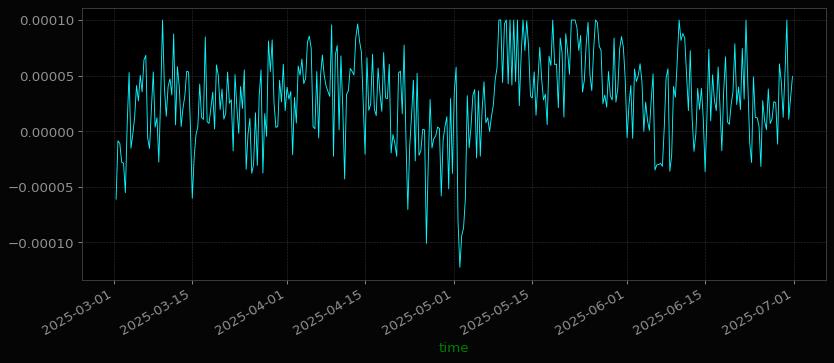

In [20]:
# transform stg._payments to pandas dataframe
df = pd.DataFrame(stg._payments)
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df.funding_rate.plot();